In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import glob
from random import randint
from utils import *
from skimage.feature import hog
from moviepy.editor import VideoFileClip
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

## Dataset Exploration
Labeled images of vehicles and non-vehicles were obtained from [KITTI vision benchmark suit](http://www.cvlibs.net/datasets/kitti/) and [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html).  
You can download the dataset for vehicles [here](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and non-vehicles [here](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip).  

-----------------------------------------------------------------------------------------------------------------------------------

Total vehicle images = 8792   
Total non-vehicle images = 8968  
Image size = 64 $\times$ 64   

The vehicle images in the database are divided as per the angle in which the images were taken. The images also reflect different lighting condiditons.   
The non-vehicle images consists of roads, trees, traffic signs, pavements or asphalts. 

In [2]:
vehicles_dir = glob.glob("./vehicles/*/*.png", recursive=True)
non_vehicles_dir = glob.glob("./non-vehicles/**/*.png", recursive=True)

print(f"The number of vehicle images = {len(vehicles_dir)}")
print(f"The number of non-vehicle images = {len(non_vehicles_dir)}")

get_img_size(vehicles_dir)
get_img_size(non_vehicles_dir)

The number of vehicle images = 8792
The number of non-vehicle images = 8968
The size of image is 64 by 64
The size of image is 64 by 64
The size of image is 64 by 64
The size of image is 64 by 64


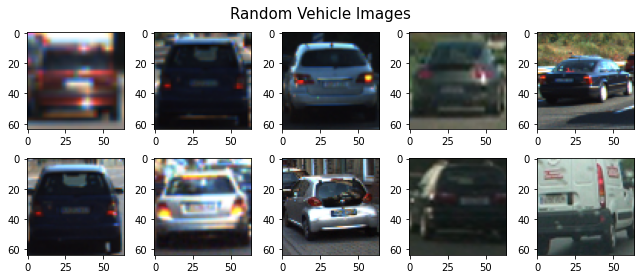

In [7]:
%run utils.py
show_random_images(image_dir = vehicles_dir,title = "Random Vehicle Images")

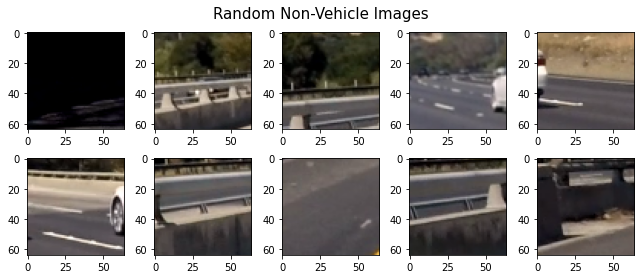

In [8]:
show_random_images(image_dir = non_vehicles_dir,title = "Random Non-Vehicle Images")

## HOG

In [9]:
def image_histogram(image, nbins=32, h_range=(0,256)):
	'''
	to explore color histogram across the 3 color channel
	bins: defines the number of equal-width bins in a range
	range: since the images are RGB range is set to (0,256)
	Comptes the histogram of color across the three channels nad returns a concatenated feature vector
	'''

	channel0 = np.histogram(image[:,:,0], bins = nbins, range = h_range)
	channel1 = np.histogram(image[:,:,1],  bins = nbins, range = h_range)
	channel2 = np.histogram(image[:,:,2],  bins = nbins, range = h_range)
	hist_color = np.concatenate((channel0[0], channel1[0], channel2[0]))
	return hist_color

def hog_features(image, orientation, pix_per_cell, cell_per_block, vis = True, feature_vec = True, norm = "L2-Hys" ):

	'''
	Computes the histogram of oriented gradients. 

	Returns: features vector, corresponding hog image (hog_image)
	
	'''
	features, hog_image = hog(image, 
								orientations = orientation,  
								pixels_per_cell = (pix_per_cell,pix_per_cell), 
								cells_per_block = (cell_per_block,cell_per_block), 
								transform_sqrt = False, 
								visualize = vis, 
								feature_vector = feature_vec, 
								block_norm = norm
							)

	return features, hog_image

def get_all_features(img_dir, arguments):
	features = []
	# if len(img_dir) == 1:
	for im in img_dir:
		image = plt.imread(im)
		
		feature_image = change_color_space(image, arguments.color_space)

		f = []
		for i in arguments.color_channel:
			channel_feature, channel_image = hog_features(feature_image[:,:,i], orientation = arguments.orientation, pix_per_cell = arguments.pix_per_cell, cell_per_block = arguments.cell_per_block)
			f.append(channel_feature)
		f = np.ravel(f)

		spatial_features = resize_image(feature_image, size=(32,32))
		hist_features = image_histogram(feature_image)


		features.append(np.concatenate((spatial_features, hist_features,f)))
	return features


### Choosing sutiable hog parameters
###### Tested on the original color scale (`RGB`) by varying `orientations`, `pixels_per_cell`, `cells_per_block`  

##### Results
| **Configuration** | **o = 10 px/c = 10 c/b = 2** | **o = 15 px/c = 9 c/b = 2** | **o = 9 px/c = 10 c/b = 2** | **o = 9 px/c = 8 c/b = 2** |
|-------------------|------------------------------|-----------------------------|-----------------------------|----------------------------|
| HLS               | 0.9899                       | 0.9916                      | 0.9879                      | 0.993                      |
| HSV               | 0.9924                       |                             | 0.9918                      | 0.9932                     |
| LUV               | 0.9873                       | 0.9876                      | 0.9856                      | 0.9899                     |
| RGB               | 0.9865                       | 0.9783                      | 0.9823                      | 0.9823                     |
| YcrCb             | 0.9896                       | 0.989                       | 0.9899                      | 0.9899                     |
| YUV               | 0.9885                       | 0.9876                      | 0.9851                      | 0.9907                     |


In [10]:
class Parameters:
	'''
	DS to store hog parameters; Used for testing parameter configurations
	'''

	def __init__(self, color_space, orientation, pix_per_cell, cell_per_block, hog_block_norm = "L2-Hys", color_channel = [0,1,2]):
		self.orientation = orientation
		self.color_space = color_space
		self.pix_per_cell = pix_per_cell
		self.cell_per_block = cell_per_block
		self.hog_block_norm = hog_block_norm
		self.color_channel = color_channel


def get_hog_features_for_parameter_set(img_dir, param_set):
	'''
	For testing different hog configurations
	Takes image and parameter set and returns a multi dimensional array such that a[i] = [image, channel1HogImage, channel2HogImage, channel3HogImage, hogParameters]
	'''
	features_set = []
	img = plt.imread(img_dir)
	
	for p in param_set:
		label = f"o = {p.orientation}, px/c = {p.pix_per_cell}, c/b = {p.cell_per_block}"
		hog_viz = []
		cspace_image = change_color_space(img, p.color_space)
		for channel in p.color_channel:
			f, viz = hog_features(cspace_image[:,:,channel], orientation = p.orientation, pix_per_cell = p.pix_per_cell, 
									cell_per_block = p.cell_per_block)
			hog_viz.append(viz)
		
		features_set.append([cspace_image, hog_viz[0], hog_viz[1], hog_viz[2], label])
	return features_set

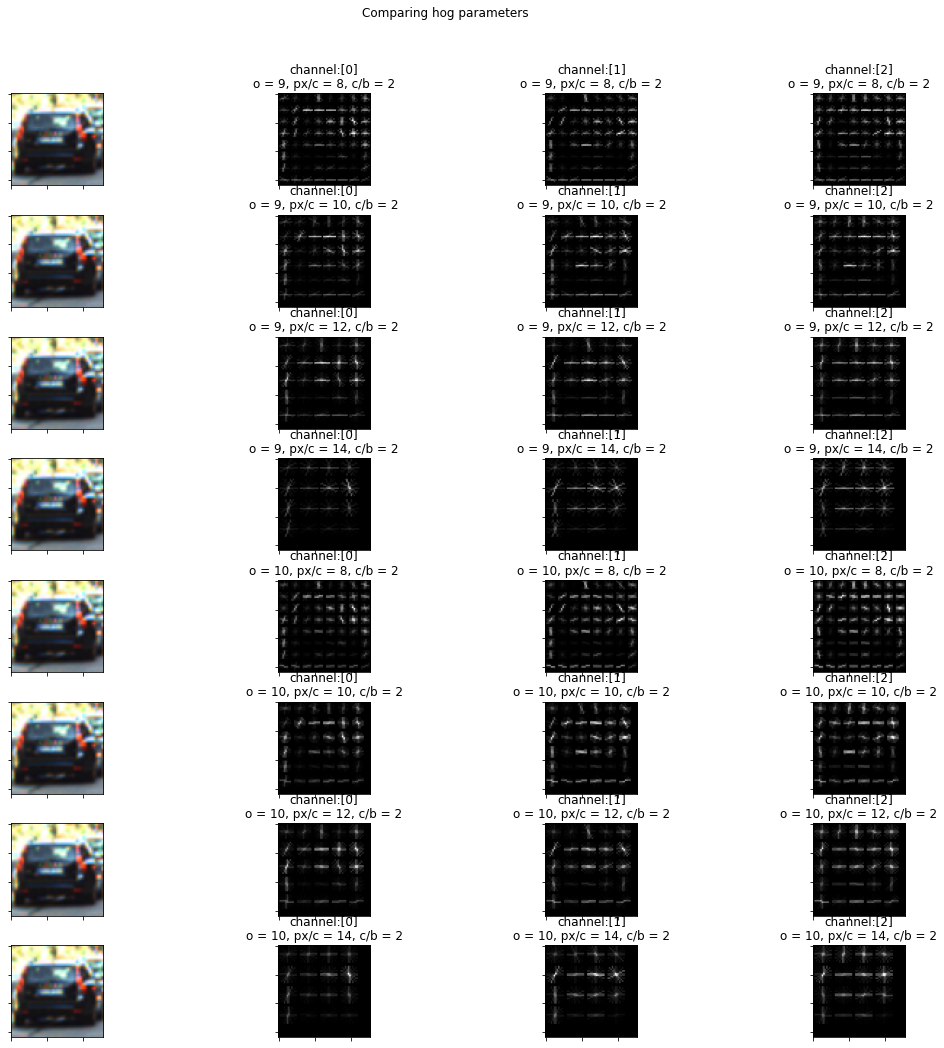

In [15]:
%run utils.py
test_set = [Parameters("RGB", 9, 8, 2),
	Parameters("RGB", 9, 10, 2),
	Parameters("RGB", 9, 12, 2),
	Parameters("RGB", 9, 14, 2),
	Parameters("RGB", 10, 8, 2),
	Parameters("RGB", 10, 10, 2),
	Parameters("RGB", 10, 12, 2),
	Parameters("RGB", 10, 14, 2)]

test_vehcle_image = vehicles_dir[randint(0,8000)]
feature_set = get_hog_features_for_parameter_set(img_dir= test_vehcle_image, param_set = test_set)
feature_set_viz(feature_set, title = "Comparing hog parameters ")




### Configuration Accuracy

In [17]:
import pickle
import pandas as pd
config_dir = glob.glob("D:/config/test/*.p")
print(config_dir)
final = {}
for conf in config_dir:
	dist_pickle = pickle.load( open(conf, "rb" ) )
	vec_fe = dist_pickle["vehicles"]
	nv_fec = dist_pickle["non-vehicles"]

	X = np.vstack((vec_fe, nv_fec)).astype(np.float64)        
               

	X_scaler = StandardScaler().fit(X)
	scaled_X = X_scaler.transform(X)


	y = np.hstack((np.ones(len(vec_fe)), np.zeros(len(nv_fec))))

	# Split up data into randomized training and test sets
	X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)


	# Use a linear SVC 
	svc = LinearSVC()

	# Check the training time for the SVC
	t=time.time()
	svc.fit(X_train, y_train)
	t2 = time.time()

	diff = t2-t
	accuracy = round(svc.score(X_test, y_test), 4)
	print(f"accuracy for : {conf} = {accuracy}")
	final[conf] = accuracy



['D:/config/test\\HLS_10_10_2.p', 'D:/config/test\\HSV_10_10_2.p', 'D:/config/test\\LUV_10_10_2.p', 'D:/config/test\\RGB_10_10_2.p', 'D:/config/test\\YCrCb_10_10_2.p', 'D:/config/test\\YUV_10_10_2.p']
accuracy for : D:/config/test\HLS_10_10_2.p = 0.9907
accuracy for : D:/config/test\HSV_10_10_2.p = 0.9924
accuracy for : D:/config/test\LUV_10_10_2.p = 0.9834
accuracy for : D:/config/test\RGB_10_10_2.p = 0.9758
accuracy for : D:/config/test\YCrCb_10_10_2.p = 0.991
accuracy for : D:/config/test\YUV_10_10_2.p = 0.989


In [20]:
dist_pickle = pickle.load( open("./configurations/test.p", "rb" ) )
car_features = dist_pickle["vehicles"]
non_car_features = dist_pickle["non-vehicles"]

### SVM

In [21]:
rand_state = np.random.randint(0, 100)


X = np.vstack((car_features, non_car_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X)

scaled_X = X_scaler.transform(X)


y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))


X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))


svc = LinearSVC()


t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Feature vector length: 8460
12.92 Seconds to train SVC...
Test Accuracy of SVC =  0.9893


### Decision Trees


In [36]:
rand_state = np.random.randint(0, 100)


X = np.vstack((car_features, non_car_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X)

scaled_X = X_scaler.transform(X)


y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))


X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))


dtree = DecisionTreeClassifier()


t=time.time()
dtree.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(dtree.score(X_test, y_test), 4))

Feature vector length: 8460
381.07 Seconds to train SVC...
Test Accuracy of SVC =  0.931


In [43]:
rand_state = np.random.randint(0, 100)


X = np.vstack((car_features, non_car_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X)

scaled_X = X_scaler.transform(X)


y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))


X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))


gauss = GaussianNB()


t=time.time()
gauss.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of gauss = ', round(gauss.score(X_test, y_test), 4))

Feature vector length: 8460
2.85 Seconds to train SVC...
Test Accuracy of gauss =  0.9181


### Sliding Window search

In [18]:
# Extracts features using hog sub-sampling and make predictions
def find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, ystart_ystop_scale, h_shift=0, visualisation=False):
    '''
    args:
    Image array
    scv : learning model
    X_scalar: normalized vector
    orient, ... : hog parameters
    ystart__stop_scale: tuple(ystar, stop, scale) for sliding window search
    
    Takes in our model and finds cars in real images
    
    Retuns: coordinates for bounding boxes
    '''
    # List of bounding box positions
    bbox_detection_list=[]
    box_vis_list=[]
    # Copy and normalise
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
       
    # Searching different size windows at different scales:
    for (ystart, ystop, scale) in ystart_ystop_scale:
        box_vis=[]
        # Crop
        img_tosearch = img[ystart:ystop, :, :]
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        hog1 = hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)[0]

        ch2 = ctrans_tosearch[:,:,1]
        hog2 = hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)[0]

        ch3 = ctrans_tosearch[:,:,2]
        hog3 = hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)[0]
        
        # Define blocks and steps as above
        nxblocks =int( (ch1.shape[1] // pix_per_cell) - cell_per_block + 3)
        nyblocks = int((ch1.shape[0] // pix_per_cell) - cell_per_block + 1 )
        nfeat_per_block = orient*cell_per_block**2

        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps =int( (nxblocks - nblocks_per_window) // cells_per_step)
        nysteps =int( (nyblocks - nblocks_per_window) // cells_per_step)

        for xb in range(nxsteps):
            xpos = xb*cells_per_step
            for yb in range(nysteps):
                ypos = yb*cells_per_step

                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = resize_image(subimg, size=spatial_size)
                hist_features = image_histogram(subimg, nbins=hist_bins)


                fe = np.hstack((spatial_features, hist_features, hog_feat)).reshape(1, -1)
                test_features = X_scaler.transform(fe)    

                # Make prediction based on trained model 
                test_prediction = svc.predict(test_features)
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                if(visualisation): 
                    pos = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                    box_vis.append(pos)
                
                if test_prediction == 1:
                    pos_cor = ((xbox_left+h_shift, ytop_draw+ystart),(xbox_left+win_draw+h_shift,ytop_draw+win_draw+ystart))
                    bbox_detection_list.append(pos_cor)
                    # Draw Detection on image
                    cv2.rectangle(draw_img,(xbox_left+h_shift, ytop_draw+ystart),(xbox_left+win_draw+h_shift,ytop_draw+win_draw+ystart),(0,0,255),6) 
        box_vis_list += [box_vis]
    return bbox_detection_list, draw_img, box_vis_list

### Parameters


In [24]:
### Parameters
spatial = 32
hist_bins = 32
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb #YCrCb best
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size= (32, 32)
heat_threshold= 4 # 12
hog_channel = [0,1,2] # Can be 0, 1, 2, or "ALL" #ALL,0 best
# ystart_ystop_scale = [(405, 510, 1), (400, 600, 1.5), (500, 710, 2.5)]


In [25]:
### Define Testinig images Images Here 
# test_images = np.array([plt.imread(i) for i in glob.glob('./test_images/test2/*.jpg')])
test_images = np.array([plt.imread("2.jpg")])
test_image_sliding=test_images[0]
ystart_ystop_scale = [(100, 400, 1), (400, 600, 1.5), (400, 1000, 1.5)]
bbox_detection_list, detections, box_vis_list = find_cars(test_image_sliding, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, ystart_ystop_scale, h_shift=500, visualisation=True)


## Sliding Window Visualization
# windows_img = draw_boxes(test_image_sliding, box_vis_list)

# f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(20,20))
# ax1.imshow(windows_img[0])
# title = "Scale: 0.9 "  + " Count: " + str(len(box_vis_list[0])) 
# ax1.set_title(title, fontsize=20)
# ax1.axis("off")
# ax2.imshow(windows_img[1])
# title = "Scale: 1.4"  + " Count: " + str(len(box_vis_list[1])) 
# ax2.set_title(title, fontsize=20)
# ax2.axis("off")
# ax3.imshow(windows_img[2])
# title = "Scale: 2.3"  + " Count: " + str(len(box_vis_list[2])) 
# ax3.set_title(title, fontsize=20)
# ax3.axis("off")




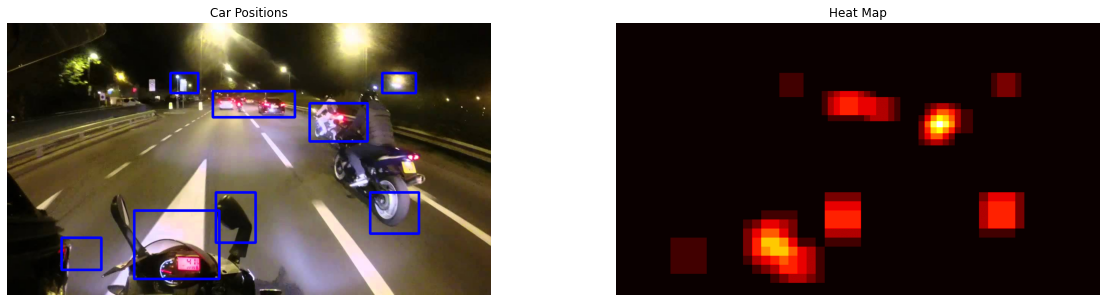

In [28]:

%run utils.py
# image = test_images[0]
# blank = np.zeros_like(image[:,:,0]).astype(np.float)
for i in range(len(test_images)):
    image = test_images[i]
    blank = np.zeros_like(image[:,:,0]).astype(np.float)
    # Using Subsampled HOG windows to get possible detections 
    bbox_detection_list, detections, box_vis_list = find_cars(image, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,ystart_ystop_scale)

    # Add heat to each box in box list
    heatmap = add_heat(blank, bbox_detection_list)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure(figsize = (20,5))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.axis('off')
    plt.show()


### Processing Video

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_result.mp4.
Moviepy - Writing video project_video_result.mp4



Moviepy - Done !
Moviepy - video ready project_video_result.mp4


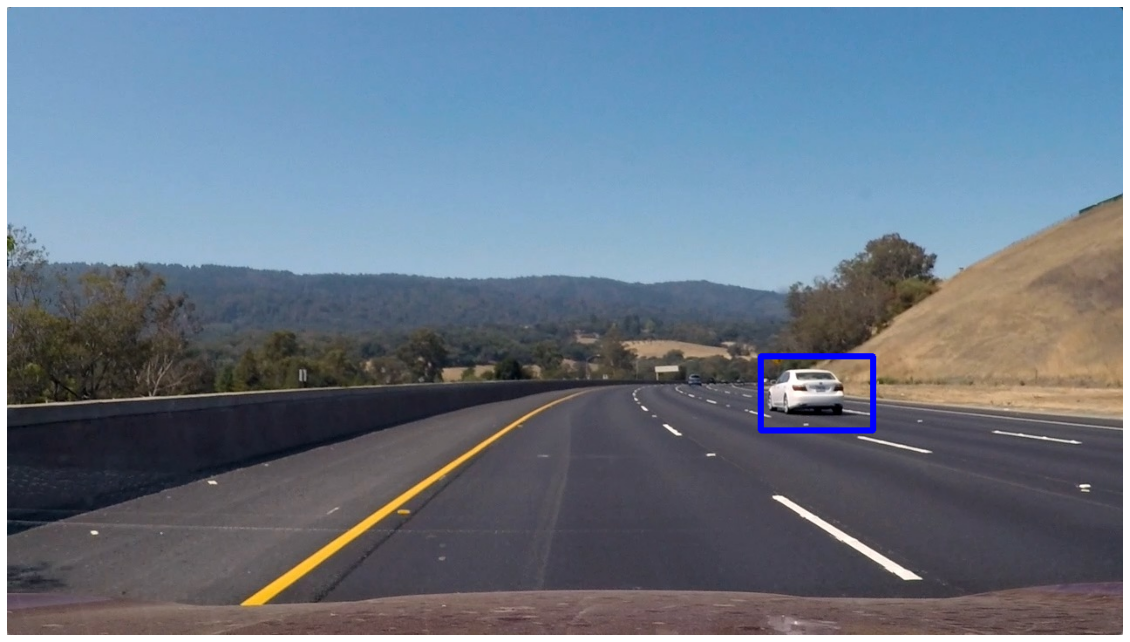

In [32]:
def process_image(img): 
    
    # Using Subsampled HOG windows to get possible detections 
    bbox_detection_list, detections, box_vis_list = find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,ystart_ystop_scale)

    blank = np.zeros_like(img[:,:,0]).astype(np.float)

    # Smoothing out previous detections
    detect_history.put_labels(bbox_detection_list)
    bbox_detection_list = detect_history.get_labels()

    # Add heat to detections
    heatmap = add_heat(blank, bbox_detection_list)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    # Draw bounding box 
    result = draw_labeled_bboxes(np.copy(img), labels)
    
    return result



# Accumulation of labels from last N frames
class Detect_history():
    def __init__ (self):
        # Number labels to store
        self.queue_len = 7 #17 13
        self.queue = []

    # Put new frame
    def put_labels(self, labels):
        if (len(self.queue) > self.queue_len):
            tmp = self.queue.pop(0)
        self.queue.append(labels)
    
    # Get last N frames hot boxes
    def get_labels(self):
        detections = []
        for label in self.queue:
            detections.extend(label)
        return detections

detect_history = Detect_history()

result = process_image(test_images[3])
plt.figure(figsize = (20,20))
plt.imshow(result)
plt.axis("off")

detect_history = Detect_history()
project_video_res = 'project_video_result.mp4'
clip1 = VideoFileClip("./test_images/project_video.mp4")
project_video_clip = clip1.fl_image(process_image)
project_video_clip.write_videofile(project_video_res, audio=False)